In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import csv
import cv2
import os
from numpy import genfromtxt
import requests
import re
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt

In [2]:
def CSV_To_Dataframe(letter, start, end):
    path = "./ASL_CSV/train/"
    data = []
    for num in range(start, end):
        df = pd.read_csv(path+letter+'/'+letter+str(num)+'.csv',sep=',',header= None)
        array = df.to_numpy()
        result = array.flatten()
        
        arr = []
        for x in result:
            replaced = re.sub("[^0-9 ]+", "", x)
            replaced = re.sub(' +', ' ', replaced).strip()
            replaced = replaced.split(" ")
            replaced = [(eval(i)/255) for i in replaced]
            arr.append(replaced)
        
        data.append(arr)
    np_data = np.array(data)
    return np_data

In [3]:
letter_to_num = {
    'a' : 1,
    'b' : 2,
    'c' : 3,
    'd' : 4,
    'e' : 5,
    'f' : 6,
    'g' : 7,
    'h' : 8,
    'i' : 9,
    'j' : 10,
    'k' : 11,
    'l' : 12,
    'm' : 13,
    'n' : 14,
    'o' : 15,
    'p' : 16,
    'q' : 17,
    'r' : 18,
    's' : 19,
    't' : 20,
    'u' : 21,
    'v' : 22,
    'w' : 23,
    'x' : 24,
    'y' : 25,
    'z' : 26,
}

In [10]:
def create_data(letters, start, end):
    data = np.concatenate([CSV_To_Dataframe(x, start, end) for x in letters])
    labels = []
    for letter in letters:
        labels = labels + ([[letter_to_num[letter]]]*(end-start))
    labels = np.array(labels)
    return data, labels

master_df, master_labels = create_data("abcdefghijklmnopqrstuvwxyz", 1, 3001) 
#test_df, test_labels = create_data("abcdefghijklmnopqrstuvwxyz", 501, 751)

MemoryError: Unable to allocate 916. MiB for an array with shape (3000, 200, 200) and data type float64

In [38]:
print(master_df.shape)
master_labels = []
test_labels = []
for i in range(1,27):
    for j in range(250):
        test_labels.append(i)
test_labels = np.array(test_labels)

print(test_labels.shape)
for i in range(1,27):
    for j in range(500):
        master_labels.append(i)
master_labels = np.array(master_labels)

print(master_labels.shape)
print(test_labels)


(13000, 200, 200)
(6500,)
(13000,)
[ 1  1  1 ... 26 26 26]


In [35]:

np.save("master_numpy", master_df)
np.save("test_numpy", test_df)
np.save("master_labels_numpy", master_labels)
np.save("test_labels_numpy", test_labels)


In [7]:
master = np.load("master_numpy.npy", allow_pickle = True)
test = np.load("test_numpy.npy", allow_pickle = True)
master_labels = np.load("master_labels_numpy.npy", allow_pickle = True)
test_labels = np.load("test_labels_numpy.npy", allow_pickle = True)


In [8]:
print(master.shape)
print(master_labels.shape)
print(test.shape)
print(test_labels.shape)

(13000, 200, 200)
(13000,)
(6500, 200, 200)
(6500,)


In [6]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(100, input_shape=(200,200)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(64, activation = 'relu'))
# model.add(keras.layers.Dense(32, activation = 'sigmoid'))
model.add(keras.layers.Dense(124))
model.add(keras.layers.Dense(64))
model.add(keras.layers.Dense(27, activation = 'softmax'))


model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"],
)

model.summary()

history = model.fit(
    master, master_labels, validation_data=(test, test_labels), batch_size=36, epochs=15
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 124)               12524     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8000      
_________________________________________________________________
dense_2 (Dense)              (None, 27)                1755      
Total params: 143,079
Trainable params: 142,879
Non-trainable params: 200
________________________________________________

204/204 - 10s - loss: 3.6746 - accuracy: 0.5237


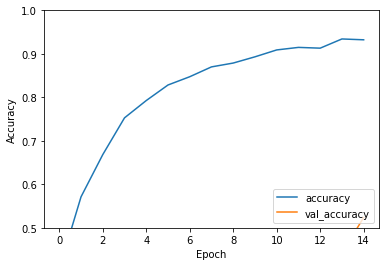

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_df,  test_labels, verbose=2)